In [1]:
from datasets import load_dataset

ds = load_dataset("bhadresh-savani/photo-to-cartoon")  

C:\Users\Reach\anaconda3\envs\cuda_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Reach\anaconda3\envs\cuda_test\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Reach\.cache\huggingface\hub\datasets--bhadresh-savani--photo-to-cartoon. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In o

Preparing Dataset

In [10]:
from datasets import load_dataset
from PIL import Image
import os

# Load dataset
ds = load_dataset("bhadresh-savani/photo-to-cartoon", split="train")

# Create output directories
os.makedirs("dataset/human", exist_ok=True)
os.makedirs("dataset/cartoon", exist_ok=True)

# Iterate and save images
for i, example in enumerate(ds):
    imgA = example['imageA']
    imgB = example['imageB']

    # Convert RGBA to RGB if needed
    if imgA.mode == 'RGBA':
        imgA = imgA.convert('RGB')
    if imgB.mode == 'RGBA':
        imgB = imgB.convert('RGB')

    # Save
    imgA.save(f"dataset/human/img_{i:03d}.jpg")
    imgB.save(f"dataset/cartoon/img_{i:03d}.jpg")

print("✅ All images saved successfully without format errors.")


Repo card metadata block was not found. Setting CardData to empty.


✅ All images saved successfully without format errors.


Prepare Paired Dataset for Pix2Pix

In [11]:
from PIL import Image
import os

input_dir = "dataset/human"
target_dir = "dataset/cartoon"
output_dir = "dataset/paired"

os.makedirs(output_dir, exist_ok=True)

for i in range(len(os.listdir(input_dir))):
    human_img = Image.open(f"{input_dir}/img_{i:03d}.jpg").resize((256, 256)).convert("RGB")
    cartoon_img = Image.open(f"{target_dir}/img_{i:03d}.jpg").resize((256, 256)).convert("RGB")

    # Concatenate side by side
    combined = Image.new('RGB', (512, 256))
    combined.paste(human_img, (0, 0))
    combined.paste(cartoon_img, (256, 0))

    combined.save(f"{output_dir}/pair_{i:03d}.jpg")

print("✅ Paired dataset created in 'dataset/paired/'")


✅ Paired dataset created in 'dataset/paired/'


Clone a Pix2Pix Repo

Run CycleGan and pix2pix

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import os
import sys
import time
import matplotlib.pyplot as plt
import torch

In [3]:
# Set working directory
os.chdir('pytorch-CycleGAN-and-pix2pix/')
sys.path.append('C:/Users/Reach/OneDrive/Desktop/Study/Machine Vission/Project')

In [4]:
sys.argv = [
    'train',
    '--dataroot', 'datasets/photo2',
    '--name', 'photo2cartoon_cyclegan',
    '--model', 'cycle_gan',
    '--display_id', '1',
    '--display_port', '8097',
    '--n_epochs', '10',
    '--n_epochs_decay', '0',
]

In [5]:
# Use GPU if available
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [6]:
import time
import visdom
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer

from options.train_options import TrainOptions
opt = TrainOptions().parse()
opt.num_threads = 0  # Ensures no multiprocessing in dataloader
opt.display_id = -1

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: datasets/photo2               	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                           
                    epoch: latest                        
              

In [7]:
from options.train_options import TrainOptions
# opt = TrainOptions().parse()
opt.num_threads = 0  # Ensures no multiprocessing in dataloader

vis = visdom.Visdom()  # Connects to Visdom server

# Set number of epochs to 50
opt.n_epochs = 25
opt.n_epochs_decay = 25  # 25 + 25 = 50 total epochs

# Create dataset, model, visualizer
dataset = create_dataset(opt)
model = create_model(opt)
model.setup(opt)
visualizer = Visualizer(opt)

# Create log dictionary
loss_log = {
    'G_A': [], 'G_B': [], 'D_A': [], 'D_B': [],
    'cycle_A': [], 'cycle_B': [], 'idt_A': [], 'idt_B': []
}

total_iters = 0
total_epochs = opt.n_epochs + opt.n_epochs_decay  # Now equals 50

# Start training
for epoch in range(opt.epoch_count, total_epochs + 1):
    print(f"\n========== Epoch {epoch}/{total_epochs} ==========")
    epoch_start_time = time.time()
    epoch_iter = 0
    epoch_losses = {key: 0.0 for key in loss_log}

    print("Starting data loading and training...")
    for i, data in enumerate(dataset):
        total_iters += opt.batch_size
        epoch_iter += opt.batch_size
        model.set_input(data)
        model.optimize_parameters()

        # Get and accumulate losses
        losses = model.get_current_losses()
        for k in epoch_losses:
            epoch_losses[k] += losses[k]

        # Print intermediate losses
        if total_iters % opt.print_freq == 0:
            t_data = 0.0
            t_comp = 0.0
            visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)

    # Print epoch summary
    print(f"[Epoch {epoch}] Time Taken: {time.time() - epoch_start_time:.2f} sec")
    for k in epoch_losses:
        avg_loss = epoch_losses[k] / len(dataset)
        loss_log[k].append(avg_loss)
        print(f"  {k}: {avg_loss:.4f}")

    # Save model checkpoint
    if epoch % opt.save_epoch_freq == 0:
        print(f"Saving model at epoch {epoch}")
        model.save_networks(epoch)

    # Save sample visuals
    if epoch % 2 == 0:
        print("Saving visuals...")
        model.compute_visuals()
        visuals = model.get_current_visuals()
        visualizer.display_current_results(visuals, epoch, save_result=True)


Setting up a new session...


dataset [UnalignedDataset] was created
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
-----------------------------------------------
create web directory ./checkpoints\photo2cartoon_cyclegan\web...

========== Epoch 1/50 ==========
Starting data loading and training...
[Epoch 1] Time Taken: 37.54 sec
  G_A: 0.7929
  G_B: 0.8890
  D_A: 0.8026
  D_B: 0.8921
  cycle_A: 2.3174
  cycle_B: 2.1111
  idt_A: 0.9886
  idt_B: 1.1133

========== Epoch 2/50 ==========
Starting data loading and training...
(epoch: 2, iters: 39, time: 0.000, data: 0.000) D_A: 0.267 G_A: 0.315 cycle_A: 1.110 idt_A: 0.629 D_B: 9.573 G_B: 0.395 cycle_B: 1.468 idt

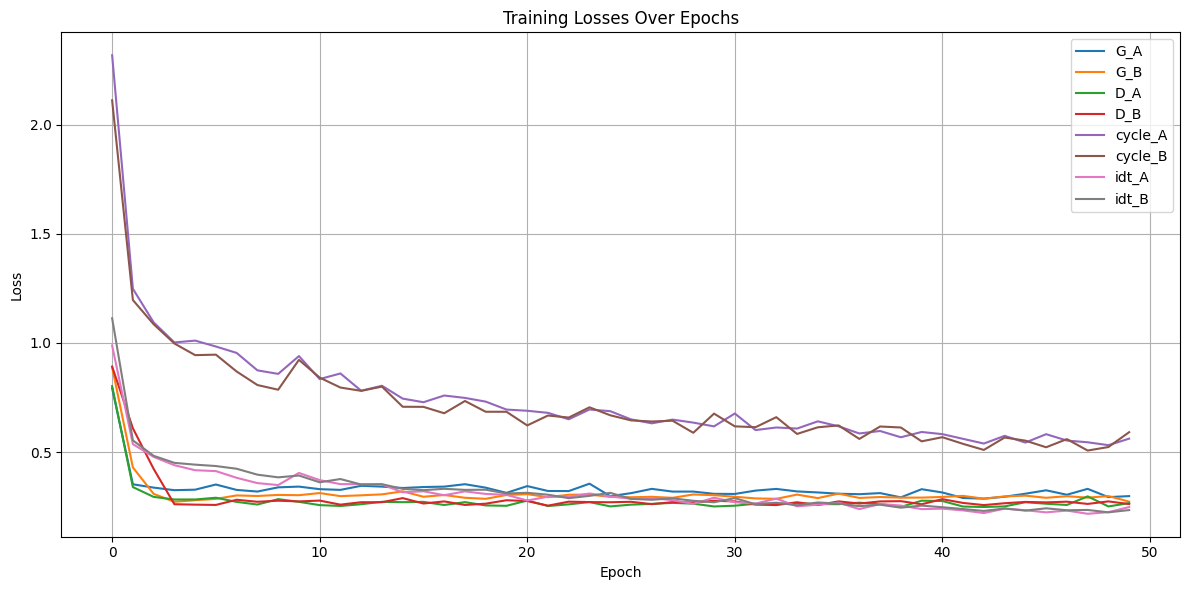

In [8]:
# ----------------------------------------
# Plotting Loss Graphs after training
# ----------------------------------------
plt.figure(figsize=(12, 6))
for k, v in loss_log.items():
    plt.plot(v, label=k)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_plot.png")
plt.show()

In [9]:
import torch
import gc

# Clear GPU cache
gc.collect()
torch.cuda.empty_cache()

Testing

In [1]:
from options.test_options import TestOptions
opt = TestOptions().parse()

# Set required test settings manually
opt.num_threads = 0
opt.batch_size = 1
opt.serial_batches = True
opt.no_flip = True
opt.display_id = -1  # Disable visdom display
opt.epoch = 'latest'  # or set to specific epoch like '50'
opt.num_test = 1000  # or however many images you want to test


ModuleNotFoundError: No module named 'options'